In [21]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import copy
from scipy.ndimage import convolve
import matplotlib.animation as animation
import warnings
import scipy

In [22]:
params = {
    "Nh":          1e5,
    "N0":          1e5,
    "R0":           4,
    "M":            1,
    "D":            3,
    "dc":           5,
    "mu":           1,
    "gamma_shape": 20, 
}
sim_params = {
    "xdomain":  100,
    "dx":         1,
    "t0":         0,
    "tf":         1,
    "dt":      0.01,
    "noise_mean": 0,
    "noise_std":0.1,
    "initial_mean": [0,0],
    "initial_var": 5,
}

In [23]:
x_range = sim_params["xdomain"]
dx = sim_params["dx"]
x_linspace = np.arange(-x_range, x_range, dx)
x_size = np.size(x_linspace)
sim_params["x_size"] = x_size

t_size = (sim_params["tf"]-sim_params["t0"])/sim_params["dt"]

s = np.zeros([x_size, x_size], dtype=int)
n = np.zeros([x_size, x_size], dtype=int) 
nh = np.zeros([x_size, x_size], dtype=int) #nh(x,t) = Nh*h(x,t) there should be a total of Nh*M elements 
coordmap = np.meshgrid(x_linspace, x_linspace)
c = nh.copy()

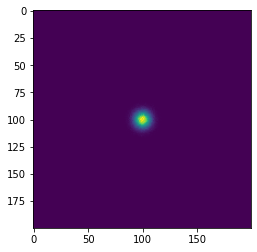

In [24]:
n0 = np.zeros(n.size, dtype=int)

N0 = int(params["N0"])
initial_position = sim_params["initial_mean"]
initial_var = sim_params["initial_var"]

x_map = coordmap[0]
y_map = coordmap[1]

rsqrd = (x_map-initial_position[0])**2 + (y_map-initial_position[0])**2

p0 = np.exp(-rsqrd/(2*(initial_var**2)))
p0 = p0/np.sum(p0) # initial prob distribution for n: Gaussian dist

p0 = p0.ravel()

for i in range(N0):
    index = np.random.choice(n.size, p=p0)
    n0[index] += 1

n = copy.deepcopy(n0.reshape(n.shape))
plt.figure()
plt.imshow(n)

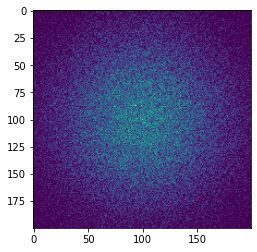

In [25]:
nh0 = np.zeros(nh.size, dtype=int)

Nh = int(params["Nh"])
M = int(params["M"])
initial_position = sim_params["initial_mean"]
initial_var = 10*sim_params["initial_var"]

x_map = coordmap[0]
y_map = coordmap[1]

rsqrd = (x_map-initial_position[0])**2 + (y_map-initial_position[0])**2

p0 = np.exp(-rsqrd/(2*(initial_var**2)))
p0 = p0/np.sum(p0) # initial prob distribution for n: Gaussian dist

p0 = p0.ravel()

for i in range(Nh*M):
    index = np.random.choice(nh.size, p=p0)
    nh0[index] += 1

nh = copy.deepcopy(nh0.reshape(nh.shape))
plt.figure()
plt.imshow(nh)

In [26]:
def coverage(h):
    return h/params["M"]

def fitness(nh):
    R0 = params["R0"]
    M = params["M"]
    Nh = params["Nh"]
    h = nh/Nh
    # check = R0*(1-coverage(h))**M
    out = np.log(R0*((1-coverage(h))**M))
    return out 

In [27]:
def virus_growth(n, f):
    dt = sim_params["dt"]
    return np.random.poisson((1-f*dt)*n) 

def num_mutants(n, mu = params["mu"], dt = sim_params["dt"]):
    p = 1-np.exp(-1*mu*dt)
    return np.random.binomial(n, p)

def num_mutation(mu, dt = sim_params["dt"]):
    out = np.random.poisson(mu*dt)
    if out >= 1 :
        return np.random.poisson(mu)
    else:
        return num_mutation(mu)

def mutation_jump(m, dx = sim_params["dx"], shape_param = params["gamma_shape"]):
    jump = np.zeros(2)
    mean = 2*dx
    theta = mean/shape_param
    
    for i in range(m):
        jump = jump + np.random.gamma(shape_param, theta, size=2)

    jump = np.round(jump)
    return jump

def immunity_gain(nh, n):
    return nh + n

def immunity_loss(nh, n):
    N = np.sum(n)
    checksum = np.sum(nh)

    for i in range(N):
        indexes = np.argwhere(nh > 0)
        index = np.random.choice(indexes.shape[0])

        nh[indexes[index, 0], indexes[index, 1]] -= 1 #There is a race condition, don't fuck with this
    
    if np.any(nh<0):
        raise ValueError("Immunity is negative")
    elif np.sum(nh) != checksum - N :
        raise ValueError("In and out total value don't match")
    

    return nh

In [28]:
def mutation(n):
    checksum = np.sum(n)

    mu = params["mu"]
    dt = sim_params["dt"]
    dx = sim_params["dx"]
    shape_param = params["gamma_shape"]

    mutation_map = num_mutants(n, mu)
    x_ind, y_ind = np.nonzero(mutation_map)
    num_mutation_sites = x_ind.size
    
    for i in range(num_mutation_sites):
        num_mutants_at_site = mutation_map[x_ind[i], y_ind[i]]
        n[x_ind[i], y_ind[i]] -= num_mutants_at_site

        for j in range(num_mutants_at_site):
            num_mutation_at_site = num_mutation(mu, dt)
            jump = mutation_jump(num_mutation_at_site, dx, shape_param)
            new_x_loc = (x_ind[i] + jump[0]).astype(int)
            new_y_loc = (y_ind[i] + jump[1]).astype(int)
            n[new_x_loc, new_y_loc] += 1

    if np.sum(n) != checksum :
        raise ValueError('mutation changed total number of n')
    elif np.any(n<0):
        raise ValueError('mutation made n negative')

    return n

In [29]:
nh = nh0.reshape(nh.shape)
n = n0.reshape(n.shape)

t_start = sim_params["t0"]
t_stop = sim_params["tf"]
t_step = sim_params["dt"]

frames_n = []
frames_nh = []
frames_f = []

N = []
fig = plt.figure()

for t in np.arange(t_start, t_stop, t_step):
# for t in np.arange(0, 5, 1): 
    f = fitness(nh)

    n = virus_growth(n, f)

    n = mutation(n)
    # print(np.any(nh<0))
    nh = immunity_gain(nh, n)
    # print(np.any(nh<0))
    nh = immunity_loss(nh, n)
    
    frames_n.append([plt.imshow(n, animated = True)])
    frames_f.append([plt.imshow(f, animated = True)])
    frames_nh.append([plt.imshow(nh, animated = True)])
    N.append([np.sum(n)])

ani_n = animation.ArtistAnimation(fig, frames_n, interval=50, blit=True, repeat_delay=1000)
ani_f = animation.ArtistAnimation(fig, frames_f, interval=50, blit=True, repeat_delay=1000)
ani_nh = animation.ArtistAnimation(fig, frames_nh, interval=50, blit=True, repeat_delay=1000)

ani_n.save("discrete_n_test.gif")
ani_nh.save("discrete_nh_test.gif")
ani_f.save("discrete_f_test.gif")

In [ ]:
nh = nh0.reshape(nh.shape)
n = n0.reshape(n.shape)

t_start = sim_params["t0"]
t_stop = sim_params["tf"]
t_step = sim_params["dt"]

N = []

# for t in np.arange(t_start, t_stop, t_step):
for t in np.arange(0, 5, 1): 
    f = fitness(nh)

    n = virus_growth(n, f)

    n = mutation(n)
    # print(np.any(nh<0))
    nh = immunity_gain(nh, n)
    # print(np.any(nh<0))
    nh = immunity_loss(nh, n)

    
    N.append([np.sum(n)])

In [ ]:
nh = nh0.reshape(nh.shape)
n = n0.reshape(n.shape)

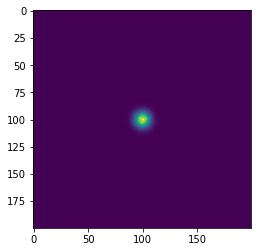

In [ ]:
plt.imshow(n)

In [ ]:
np.sum(nh)

1000

In [ ]:
R0 = params["R0"]
M = params["M"]
Nh = params["Nh"]
h = nh/Nh
R0*((1-coverage(h))**M)
# out = np.log(R0*((1-coverage(h))**M))

array([[3.99992, 4.     , 3.99996, ..., 4.     , 4.     , 4.     ],
       [4.     , 4.     , 3.99996, ..., 4.     , 4.     , 4.     ],
       [4.     , 3.99996, 4.     , ..., 4.     , 4.     , 4.     ],
       ...,
       [4.     , 4.     , 4.     , ..., 4.     , 4.     , 4.     ],
       [4.     , 4.     , 3.99996, ..., 4.     , 4.     , 4.     ],
       [4.     , 4.     , 4.     , ..., 4.     , 4.     , 3.99996]])

0.002